# YOLO Baseline en SportsMOT 🏀⚽🏐

En este notebook:

- Cargamos una o varias secuencias de **SportsMOT** en formato MOTChallenge.
- Ejecutamos un modelo **YOLOv8 (Ultralytics)** pre-entrenado en COCO.
- Filtramos clases relevantes (`person`, `sports ball`).
- Visualizamos detecciones sobre los frames.
- Guardamos las detecciones en una estructura estándar que usaremos luego para tracking.

Este es un **baseline de detección** (sin fine-tuning) que servirá como punto de partida para:

- Comparar contra un YOLO fine-tuneado.
- Construir el pipeline de tracking (IoU + Optical Flow).

Los pesos de YOLO se guardan en la carpeta `models/` en la raíz del proyecto.

## 1. Rutas del proyecto y imports básicos 📁

In [24]:
from pathlib import Path
import configparser
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
from tqdm import tqdm
import requests

plt.rcParams["figure.figsize"] = (10, 7)

# Detectar raíz del proyecto y carpeta de datos
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_ROOT = PROJECT_ROOT / "data"

DATASET_ROOT = DATA_ROOT / "dataset"   # contiene train/val/test
SPLITS_DIR = DATA_ROOT / "splits_txt"

VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
    print("PROJECT_ROOT:", PROJECT_ROOT)
    print("DATA_ROOT:", DATA_ROOT)
    print("DATASET_ROOT:", DATASET_ROOT)
    print("SPLITS_DIR:", SPLITS_DIR)

## 2. Leer splits y elegir una secuencia de ejemplo 📄

In [5]:
def read_split_file(path: Path):
    if not path.exists():
        print(f"⚠ WARNING: split file no encontrado: {path}")
        return set()
    with path.open("r") as f:
        lines = [ln.strip() for ln in f.readlines()]
    return {ln for ln in lines if ln and not ln.startswith("#")}


train_list = read_split_file(SPLITS_DIR / "train.txt")
basketball_list = read_split_file(SPLITS_DIR / "basketball.txt")

print("Nº secuencias train:", len(train_list))
print("Nº secuencias basketball:", len(basketball_list))

# Ejemplo: elegir una secuencia de basketball que esté en train
candidate_seqs = sorted(train_list.intersection(basketball_list))
if not candidate_seqs:
    # fallback: simplemente la primera de train
    candidate_seqs = sorted(train_list)

example_seq_name = candidate_seqs[0]
print("Usaremos la secuencia:", example_seq_name)

example_seq_dir = DATASET_ROOT / "train" / example_seq_name

VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:    
    print("Carpeta de la secuencia:", example_seq_dir)


Nº secuencias train: 3
Nº secuencias basketball: 1
Usaremos la secuencia: v_-6Os86HzwCs_c009


## 3. Leer seqinfo.ini y listar frames de la secuencia 🧩

In [8]:
def parse_seqinfo(seq_dir: Path) -> dict:
    ini_path = seq_dir / "seqinfo.ini"
    if not ini_path.exists():
        raise FileNotFoundError(f"No se encontró seqinfo.ini en {seq_dir}")

    config = configparser.ConfigParser()
    config.read(ini_path)
    seq = config["Sequence"]

    return {
        "name": seq.get("name", seq_dir.name),
        "im_width": int(seq.get("imWidth")),
        "im_height": int(seq.get("imHeight")),
        "seq_length": int(seq.get("seqLength")),
        "fps": float(seq.get("frameRate")),
        "img_dir": seq.get("imDir", "img1"),
    }


seqinfo = parse_seqinfo(example_seq_dir)
seqinfo


{'name': 'v_-6Os86HzwCs_c009',
 'im_width': 1280,
 'im_height': 720,
 'seq_length': 500,
 'fps': 25.0,
 'img_dir': 'img1'}

Listamos los frames disponibles:

In [9]:
img_dir = example_seq_dir / seqinfo["img_dir"]
all_frames = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in (".jpg", ".png")])

print(f"Nº de frames en {example_seq_name}: {len(all_frames)}")
print("Ejemplos:", all_frames[:5])


Nº de frames en v_-6Os86HzwCs_c009: 500
Ejemplos: [PosixPath('/Users/davidgiraldovalencia/Documents/Universidad_Maestría/Visión por computador/Deteccion_Seguimiento_Objetos_Video/data/dataset/train/v_-6Os86HzwCs_c009/img1/000001.jpg'), PosixPath('/Users/davidgiraldovalencia/Documents/Universidad_Maestría/Visión por computador/Deteccion_Seguimiento_Objetos_Video/data/dataset/train/v_-6Os86HzwCs_c009/img1/000002.jpg'), PosixPath('/Users/davidgiraldovalencia/Documents/Universidad_Maestría/Visión por computador/Deteccion_Seguimiento_Objetos_Video/data/dataset/train/v_-6Os86HzwCs_c009/img1/000003.jpg'), PosixPath('/Users/davidgiraldovalencia/Documents/Universidad_Maestría/Visión por computador/Deteccion_Seguimiento_Objetos_Video/data/dataset/train/v_-6Os86HzwCs_c009/img1/000004.jpg'), PosixPath('/Users/davidgiraldovalencia/Documents/Universidad_Maestría/Visión por computador/Deteccion_Seguimiento_Objetos_Video/data/dataset/train/v_-6Os86HzwCs_c009/img1/000005.jpg')]


Para que sea rápido, vamos a trabajar solo con un subconjunto (por ejemplo, cada 5 frames):

In [17]:
# Para que sea más rápido: muestreamos cada N frames
STEP = 5 
sampled_frames = all_frames[::STEP]
len(sampled_frames)


100

## 4. Cargar YOLO (Ultralytics) 🦾

In [20]:
# Carpeta de modelos en la raíz del proyecto
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

MODEL_NAME = "yolov8n.pt"  # puedes cambiar a 'yolov8s.pt', etc.
MODEL_PATH = MODELS_DIR / MODEL_NAME

# URL oficial de Ultralytics para pesos de YOLOv8
MODEL_URL = f"https://github.com/ultralytics/assets/releases/download/v0.0.0/{MODEL_NAME}"

if MODEL_PATH.exists():
    print("✔ Modelo ya existe")
else:
    print("⬇️ Descargando modelo YOLO")
    r = requests.get(MODEL_URL, stream=True)
    r.raise_for_status()
    with open(MODEL_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("✔ Descarga completa.")

# Cargar modelo desde la carpeta models
model = YOLO(str(MODEL_PATH))
print("Modelo cargado")

# Ver clases disponibles
model.names



✔ Modelo ya existe
Modelo cargado


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## 5. IDs de clases relevantes y función de detección 🎯

In [21]:
# Mapear nombre -> id de clase
name_to_id = {name: idx for idx, name in model.names.items()}
person_id = name_to_id.get("person", None)
ball_id = name_to_id.get("sports ball", None)

print("person_id:", person_id)
print("sports_ball_id:", ball_id)


def yolo_detect_frame(image_bgr, frame_id: int, seq_name: str):
    """
    Ejecuta YOLO sobre una imagen BGR (OpenCV).
    Devuelve lista de detecciones en formato MOT-like:
      sequence, frame, x, y, w, h, conf, cls_id, cls_name
    """
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    results = model.predict(image_rgb, verbose=False)
    boxes = results[0].boxes

    detections = []
    if boxes is None or len(boxes) == 0:
        return detections

    xyxy = boxes.xyxy.cpu().numpy()
    confs = boxes.conf.cpu().numpy()
    cls_ids = boxes.cls.cpu().numpy().astype(int)

    for (x1, y1, x2, y2), conf, cls_id in zip(xyxy, confs, cls_ids):
        cls_name = model.names[int(cls_id)]

        # Filtrar por clases relevantes
        if cls_id not in [person_id, ball_id]:
            continue

        x = float(x1)
        y = float(y1)
        w = float(x2 - x1)
        h = float(y2 - y1)

        detections.append({
            "sequence": seq_name,
            "frame": frame_id,
            "x": x,
            "y": y,
            "w": w,
            "h": h,
            "conf": float(conf),
            "cls_id": int(cls_id),
            "cls_name": cls_name,
        })

    return detections


person_id: 0
sports_ball_id: 32


## 6. Ejecutar YOLO sobre los frames muestreados 🚀

In [22]:
all_dets = []

for frame_path in tqdm(sampled_frames, desc="Detección YOLO"):
    frame_id = int(frame_path.stem)  # asume nombres tipo 000001.jpg

    img_bgr = cv2.imread(str(frame_path))
    if img_bgr is None:
        print("⚠ No se pudo leer:", frame_path)
        continue

    dets = yolo_detect_frame(img_bgr, frame_id, example_seq_name)
    all_dets.extend(dets)

det_df = pd.DataFrame(all_dets)
det_df.head()


Detección YOLO: 100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


,sequence,frame,x,y,w,h,conf,cls_id,cls_name
0,v_-6Os86HzwCs_c009,1,458.181396,496.385742,56.650757,97.304443,0.788891,0,person
1,v_-6Os86HzwCs_c009,1,1035.492676,371.656799,64.161133,120.854004,0.783783,0,person
2,v_-6Os86HzwCs_c009,1,104.503922,245.641418,40.465927,134.354858,0.616957,0,person
3,v_-6Os86HzwCs_c009,1,859.708618,278.640381,33.150146,91.484558,0.616271,0,person
4,v_-6Os86HzwCs_c009,1,226.590363,402.199585,72.834412,127.796204,0.578812,0,person


Guardar detecciones para usarlas luego en tracking:

In [26]:
DETS_DIR = DATA_ROOT / "detections_yolo"
DETS_DIR.mkdir(parents=True, exist_ok=True)

out_path = DETS_DIR / f"{example_seq_name}_yolov8n_step{STEP}.csv"
det_df.to_csv(out_path, index=False)

VERBOSE = False   # cambiar a True en caso de querer ver las rutas
if VERBOSE:
    print("Detecciones guardadas en:", out_path)

## 7. Visualizar detecciones sobre algunos frames 👁️

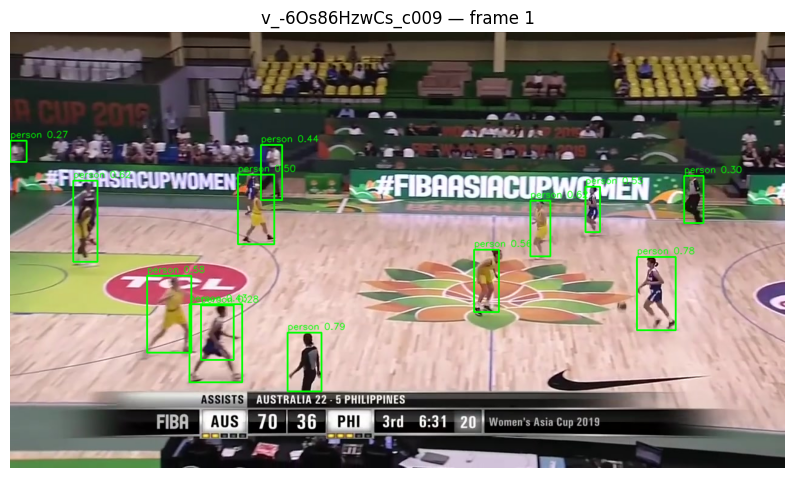

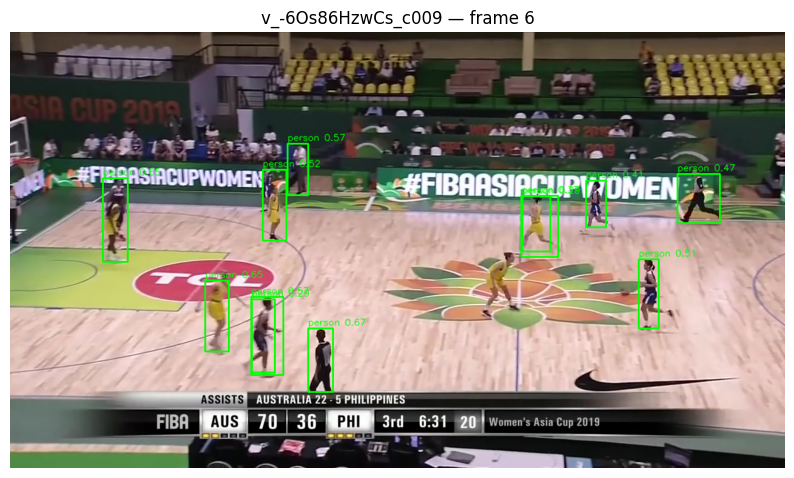

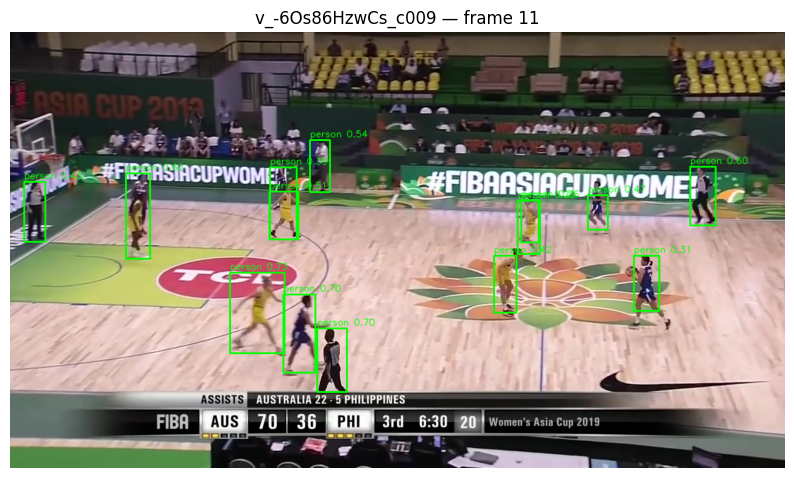

In [27]:
def visualize_detections_on_frame(frame_path: Path,
                                  det_df: pd.DataFrame,
                                  max_dets: int = 50):
    frame_id = int(frame_path.stem)
    img_bgr = cv2.imread(str(frame_path))
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    dets = det_df[det_df["frame"] == frame_id]
    dets = dets.sort_values("conf", ascending=False).head(max_dets)

    for _, row in dets.iterrows():
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]
        cls_name = row["cls_name"]
        conf = row["conf"]

        color = (0, 255, 0) if cls_name == "person" else (255, 0, 0)
        cv2.rectangle(img, (int(x), int(y)),
                      (int(x + w), int(y + h)),
                      color, 2)
        cv2.putText(
            img,
            f"{cls_name[:6]} {conf:.2f}",
            (int(x), int(y) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{example_seq_name} — frame {frame_id}")
    plt.show()


# Visualizar los primeros 3 frames muestreados
for fp in sampled_frames[:3]:
    visualize_detections_on_frame(fp, det_df)


## 8. Comparar con GT (gt/gt.txt) 📐

In [28]:
def load_gt(seq_dir: Path) -> pd.DataFrame:
    gt_path = seq_dir / "gt" / "gt.txt"
    cols = ["frame", "id", "x", "y", "w", "h", "conf", "cls", "vis"]
    return pd.read_csv(gt_path, header=None, names=cols)

gt_df = load_gt(example_seq_dir)
gt_df.head()


,frame,id,x,y,w,h,conf,cls,vis
0,1,0,102,271,43,116,1,1,1
1,1,1,211,403,110,138,1,1,1
2,1,2,297,449,88,129,1,1,1
3,1,3,110,248,34,104,1,1,1
4,1,4,383,257,55,91,1,1,1


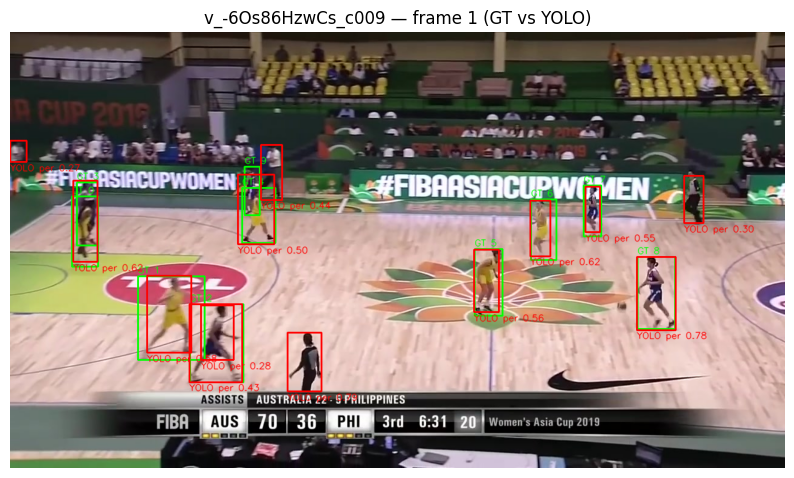

In [29]:
def visualize_detections_vs_gt(frame_path: Path,
                               det_df: pd.DataFrame,
                               gt_df: pd.DataFrame):
    frame_id = int(frame_path.stem)
    img_bgr = cv2.imread(str(frame_path))
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # GT
    gt_fr = gt_df[gt_df["frame"] == frame_id]
    for _, row in gt_fr.iterrows():
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]
        cv2.rectangle(img, (int(x), int(y)),
                      (int(x + w), int(y + h)),
                      (0, 255, 0), 2)
        cv2.putText(
            img,
            f"GT {int(row['id'])}",
            (int(x), int(y) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    # Predicciones
    dets = det_df[det_df["frame"] == frame_id]
    for _, row in dets.iterrows():
        x, y, w, h = row["x"], row["y"], row["w"], row["h"]
        cls_name = row["cls_name"]
        conf = row["conf"]
        cv2.rectangle(img, (int(x), int(y)),
                      (int(x + w), int(y + h)),
                      (255, 0, 0), 2)
        cv2.putText(
            img,
            f"YOLO {cls_name[:3]} {conf:.2f}",
            (int(x), int(y) + int(h) + 15),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{example_seq_name} — frame {frame_id} (GT vs YOLO)")
    plt.show()


# Ejemplo de comparación
visualize_detections_vs_gt(sampled_frames[0], det_df, gt_df)
